# Model calibration: toy problem
This example can be found in Section 5.3 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

## 1. Model $\textbf{f}(\textbf{X})$

`Model` should have attributes that define the number of input and output parameters: `model.n_inputs` and `model.n_outputs`

In [2]:
class Model:
    """
    Base class for models used in optimisation and Bayesian inference.

    Subclasses must implement the run and __call__ method.
    """

    def __init__(self, x, y_observed=None):
        """
        x : list or array-like
            The independent variables (e.g., strain).

        y_observed : list or array-like
            The observed values of the dependent variables (e.g., stress).
        """
        self.x = x
        self.y_observed = y_observed

    def run(self):
        """
        Run the model to generate predictions

        This method must be implemented by subclasses and should
        return predictions computed by the model based on the 
        provided parameters.

        Returns
        -------
        list
            Model predictions corresponding to the input variables.
        """
        raise NotImplementedError("Subclasses must implement the run method.")

    def __call__(self, *args, **kwargs):
        """
        Evaluate the performance of the model 
        
        Quantify how well the model predictions match 
        the observed data (e.g., mean squared error).

        Parameters
        ----------
        *args : tuple
            Positional arguments.

        **kwargs : dict
            Keyword arguments.

        Returns
        -------
        float
            A score representing the performance of the model.
        """
        raise NotImplementedError("Subclasses must implement __call__ method.")


class LinearElasticPerfectlyPlastic(Model):
    """
    Linear elastic-perfectly plastic material.
    """

    def __init__(self, x, y_observed=None):
        """
        Parameters
        ----------
        x : list or array-like
            The independent variables (e.g., strain).

        y_observed : list or array-like
            The observed values of the dependent variables (e.g., stress).
        """
        super().__init__(x, y_observed)

    def run(self, parameters):
        """
        Compute stress values for a given set of parameters
    
        Parameters
        ----------
        parameters : list
            A list containing two values:
            - Young's Modulus (E)
            - Yield Stress (σ_y)
    
        Returns
        -------
        list
            Computed stress values corresponding to the input strain values
        """
        if len(parameters) != 2:
            raise ValueError(
                "LinearElasticPerfectlyPlastic model expects two parameters."
            )

        E, stress_y = parameters
        strain_y = stress_y / E
        stress = []

        for strain in self.x:
            if strain <= strain_y:
                stress.append(E * strain)
            else:
                stress.append(stress_y)

        return stress

    def __call__(self, candidate):
        """
        Compute the mean squared error between predicted and observed values
    
        Parameters
        ----------
        candidate : list
            A set of candidate material parameters [E, σ_y].
    
        Returns
        -------
        float
            Mean squared error between predicted and observed stress values.
        """
        return np.mean((self.y_observed - self.run(candidate)) ** 2)

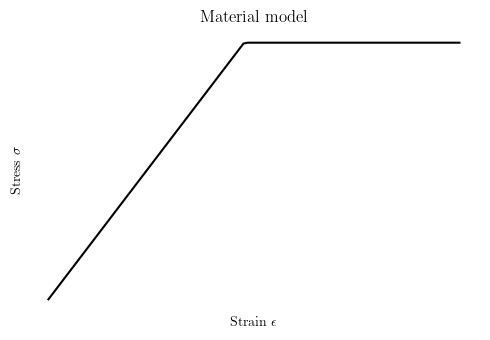

In [3]:
E = 210
stress_y = 0.25
strain = np.linspace(0, 2.5e-3, 100)
true_model = LinearElasticPerfectlyPlastic(strain)
stress = true_model.run(np.array([E, stress_y]))

plt.figure(figsize=(5, 3.5))
plt.plot(strain, stress, color='k')
plt.title("Material model")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

## 2. Generating synthetic data

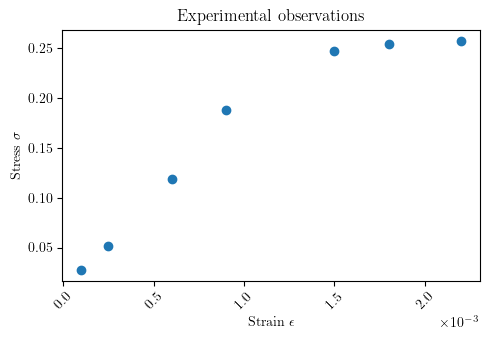

In [4]:
sigma = 0.01  # standard deviation of the noise
strain_observed = np.array([.1, .25, .6, .9, 1.5, 1.8, 2.2]) * 1e-3
stress_observed = (LinearElasticPerfectlyPlastic(strain_observed).run(np.array([E, stress_y])) 
                    + np.random.normal(scale=sigma, size=strain_observed.shape[0]))

plt.figure(figsize=(5, 3.5))
plt.scatter(strain_observed, stress_observed, label="Observation")
plt.title("Experimental observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.xticks(rotation=45)
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2)) 
plt.tight_layout()

## x. Design of Experiments

In [5]:
def generate_parameter_grid(a_range=(160, 250), b_range=(0.05, 0.5), num_points=5, noise_scale=0.1):
    """
    Generate a grid of parameter values for a and b.
    """
    a_values = np.linspace(a_range[0], a_range[1], num_points)
    b_values = np.linspace(b_range[0], b_range[1], num_points)

    a_noise = (a_range[1] - a_range[0]) * noise_scale
    b_noise = (b_range[1] - b_range[0]) * noise_scale

    return [(a + np.random.uniform(-a_noise, a_noise), 
             b + np.random.uniform(-b_noise, b_noise)) 
            for a in a_values for b in b_values]

Text(0, 0.5, 'b')

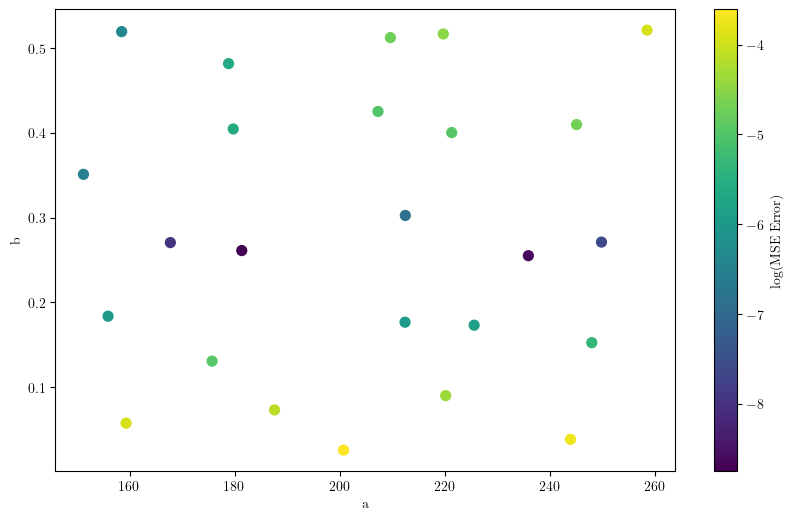

In [6]:
model = LinearElasticPerfectlyPlastic(strain_observed, stress_observed)

parameter_grid = generate_parameter_grid()
a_samples, b_samples, mse = [], [], []
for a, b in parameter_grid:
    candidate = np.array([a, b])
    a_samples.append(a)
    b_samples.append(b)
    mse.append(model(candidate))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(a_samples, b_samples, c=np.log(mse), cmap='viridis', s=50)
plt.colorbar(scatter, label='log(MSE Error)')
plt.xlabel('a')
plt.ylabel('b')

## x. Surrogate Model

Should `SurrogateModel` inherit from `Model`?

In [7]:
from abc import ABC, abstractmethod
import GPy    


class SurrogateModel(ABC):
    """
    Abstract base class for surrogate models

    TODO: SurrogateModel(Model)
    """
    
    @abstractmethod
    def fit(self, X, y):
        """
        Fit the surrogate model to training data
        """
        pass
    
    @abstractmethod
    def predict(self, X):
        """
        Make predictions with uncertainty
        """
        pass
    
    @property
    @abstractmethod
    def parameters(self):
        """
        Get model parameters
        """
        pass


class GaussianProcessModel(SurrogateModel):
    """
    Gaussian Process implementation of surrogate model
    """    
    def __init__(self, input_dim, kernel=None):
        
        self.input_dim = input_dim
        self.kernel = kernel or GPy.kern.RBF(input_dim=input_dim, ARD=True)
        self.model = None
        
    def fit(self, X, y):
        """
        Fit GP model to data
        
        Args:
            X: Input features (n_samples, n_features)
            y: Target values (n_samples, 1)
        """
        self.model = GPy.models.GPRegression(X, y, self.kernel)
        self.model.optimize_restarts(num_restarts=5, verbose=False)
        return self
        
    def predict(self, X):
        """
        Make predictions with uncertainty

        Predict the residual (i.e. Mean Square Error (MSE) between model with input parameters X 
        and experimental data)

        Returns:
            tuple: (mean predictions, variances)
        """
        if self.model is None:
            raise RuntimeError("Model must be fitted before making predictions")
        return self.model.predict(X)

    def __call__(self, X):
        mean, _ = self.predict(np.atleast_2d(X))
        return np.exp(mean[0, 0])

    def evaluate(self, X):
        mean, _ = self.predict(np.atleast_2d(X))
        return mean[0, 0]
    
    @property
    def parameters(self):
        """
        Get model parameters
        """
        if self.model is None:
            return None
        return {
            'lengthscale': self.model.kern.lengthscale.values,
            'variance': self.model.kern.variance.values[0]
        }

In [8]:
samples = np.column_stack((a_samples, b_samples, mse))

X = samples[:, :2]
Y = np.log(samples[:, 2].reshape(-1, 1))

matern = GPy.kern.Matern32(input_dim=2, ARD=True)
gp_model = GaussianProcessModel(input_dim=2, kernel=matern)
gp_model.fit(X, Y)

 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/markhobbs/.local/share/virtualenvs/model-calibration-1ITwTbKo/lib/python3.11/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


In [9]:
print(model(np.array([200, 0.2])))
print(gp_model(np.array([200, 0.2])))

0.0012309413676776515
0.0007708655405581145


### Visualise the fitted GP

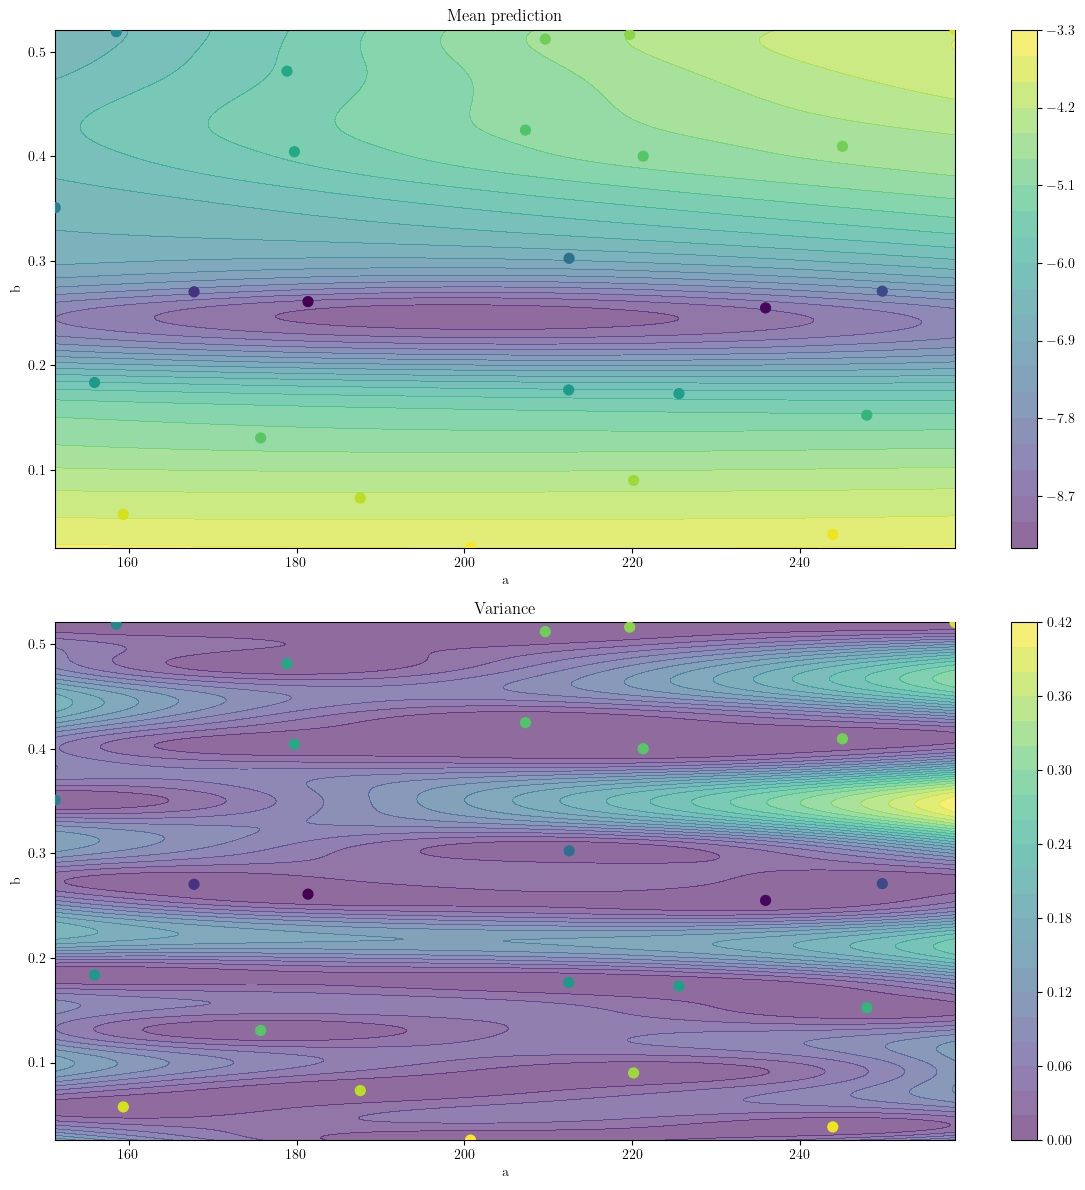

In [10]:
a_grid, b_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 1000),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 1000)
)
X_pred = np.column_stack([a_grid.ravel(), b_grid.ravel()])

mean, variance = gp_model.predict(X_pred)
mean = mean.reshape(a_grid.shape)
variance = variance.reshape(a_grid.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Mean plot
scatter = ax1.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50, zorder=5)
contour_mean = ax1.contourf(a_grid, b_grid, mean, levels=20, cmap='viridis', alpha=0.6)
ax1.set_title('Mean prediction')
ax1.set_xlabel('a')
ax1.set_ylabel('b')
fig.colorbar(contour_mean, ax=ax1)

# Variance plot
scatter = ax2.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50, zorder=5)
contour_variance = ax2.contourf(a_grid, b_grid, variance, levels=20, cmap='viridis', alpha=0.6)
ax2.set_title('Variance')
ax2.set_xlabel('a')
ax2.set_ylabel('b')
fig.colorbar(contour_variance, ax=ax2)

plt.tight_layout()

## 3. Optimisation

In [11]:
from scipy.optimize import minimize

In [12]:
result = minimize(model, x0=[220, 0.1], method='Nelder-Mead', options={'maxiter': 1000000})
print(result.x, model(result.x))

[206.41884813   0.25301878] 1.891808987634452e-05


In [13]:
result = minimize(gp_model, x0=[220, 0.1], method='Nelder-Mead', options={'maxiter': 1000000})
print(result.x, gp_model(result.x))

[200.65880017   0.24672051] 0.00010122640438647722


## 4. Prior

In [14]:
class Prior:

    def __init__(self, mean=np.array([0, 0]), std_dev=np.array([1, 1])):
        """
        Initialise the multivariate normal prior distribution.

        Parameters
        ----------
        mean : array-like, optional
            Mean vector of the multivariate normal distribution. Default is np.array([0, 0]).

        std_dev : array-like
            Standard deviation vector of the multivariate normal distribution. Default is np.array([1, 1]).
        """
        self.mean = np.array(mean)
        self.std_dev = np.array(std_dev)
        self.cov = np.diag(self.std_dev**2)

    def evaluate(self, x):
        """
        Evaluate the prior function at the given value(s) of x.

        Parameters
        ----------
        x : array-like
            The value(s) at which to evaluate the prior function.

        Returns
        -------
        array-like
            The prior probability density at the given value(s).
        """
        return scipy.stats.multivariate_normal.pdf(x, mean=self.mean, cov=self.cov)

## 5. Likelihood

In [15]:
class Likelihood:

    def __init__(self, y, sigma, model):
        """
        y : ndarray
            Observed data
        """
        self.y = y
        self.sigma = sigma
        self.model = model

    def evaluate(self, x):
        """
        x : float or array-like
            The value(s) of the model parameters.
        """
        residual = self._compute_residual(x)
        return (
            1
            / (self.sigma * np.sqrt(2 * np.pi))
            * np.exp(-0.5 * (residual / self.sigma**2))
        )

    def _compute_residual(self, x):
        if isinstance(self.model, Model):
            return np.sum((self.y - self.model.run(x)) ** 2)
        elif isinstance(self.model, SurrogateModel):
            return self.model(x)

## 6. Posterior

In [16]:
class Posterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.prior.evaluate(x) * self.likelihood.evaluate(x)

In [17]:
prior = Prior(mean=np.array([200, 0.29]), std_dev=np.array([25, 0.025]))

likelihood = Likelihood(stress_observed, sigma, model)
posterior = Posterior(prior, likelihood)

surrogate_likelihood = Likelihood(stress_observed, sigma, gp_model)
surrogate_posterior = Posterior(prior, surrogate_likelihood)

## 8. Adaptive Metropolis Hastings (`Sampler` and `Proposal` class)

In [18]:
from tqdm import tqdm


class Sampler:

    def __init__(self, posterior, proposal, steps, init):
        self.posterior = posterior
        self.proposal = proposal
        self.steps = int(steps)  # n_samples
        self.init = init
        self.samples = None

    def sample(self):
        """
        Sampling
        """
        self.samples = [self.init.copy()]
        for _ in tqdm(range(self.steps), desc="Sampling"):
            self._sample_step()

    def get_samples(self):
        """
        Returns the samples
        """
        return np.array(self.samples)

    def _sample_step(self):
        """
        Draw a new sample
        """
        point = self.samples[-1]
        proposal = self.proposal.draw(self.samples)
        self.samples.append(self._accept_or_reject(point, proposal))

    def _accept_or_reject(self, x_i, x_p):
        """
        Accept of reject a new candidate

        Parameters
        ----------
        x_i : ndarray
            Current sample

        x_p : ndarray
            New sample (x_p) is proposed by drawing from a proposal
            distribution

        n_accept : int
            Count of accepted samples

        Returns
        -------

        """
        alpha = self._compute_acceptance_ratio(x_i, x_p)
        u = np.random.uniform(low=0.0, high=1.0)
        if u <= alpha:  # Accept proposal
            return x_p
        else:  # Reject proposal
            return x_i

    def _compute_acceptance_ratio(self, x_i, x_p):
        return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))

In [19]:
class AdaptiveProposal:
    """
    Adaptive proposal class - update the the covariance matrix of the proposal
    distribution using existing knowledge of the posterior

    Haario, H., Saksman, E., and Tamminen, J. (1999). Adaptive proposal
    distribution for random walk metropolis algorithm. Computational
    Statistics, 14(3):375-395. 1, 2

    Attributes
    ----------
    update_freq: int
        Proposal distribution update frequency (default = 1000). The
        frequency at which the proposal distribution is updated.

    n_K : ndarray
        Number of samples / update frequency

    R_0 : ndarray (floats)
        Initial covariance matrix (this can be chosen as the identify matrix
        if you have no prior knowledge)

    R_t : ndarray (floats)
        Updated covariance matrix

    i : int
        Counter to track how many times the proposal has been called

    Notes
    -----
    - TODO: is n_K equal to n_samples?
    - TODO: gamma is missing from the draw method
    """

    def __init__(self, cov, step_size=2.38, update_freq=1000):
        self.cov = cov
        self.step_size = step_size
        self.update_freq = update_freq
        self.R_t = cov
        self.i = 0

    def draw(self, samples):
        """
        Draw x (candidate) from proposal distribution q

        Parameters
        ----------
        x_i : ndarray
            Current sample

        Returns
        -------
        x_p : ndarray
            Proposed sample (candidate sample)

        """
        self.i += 1
        if self.i % self.update_freq == 0:
            self._adapt_cov(samples)
        return np.random.multivariate_normal(samples[-1], self.R_t)

    def _adapt_cov(self, K):
        """
        Parameters
        ----------
        K : ndarray

        Returns
        -------
        R_t : ndarray (floats)
            Updated covariance matrix
        """
        K_tilde = self._compute_K_tilde(K)
        self.R_t = (1 / (len(K) - 1)) * np.matmul(np.transpose(K_tilde), K_tilde)

    def _compute_K_tilde(self, K):
        """
        Calculate the centred matrix

        Parameters
        ----------
        K : ndarray
            Sample chain - all previous samples are stored in matrix K of size
            n_k x n_p, where n_k is... and n_p is the number of unknown
            parameters. Each row represents one sampled point.

        K_mean : ndarray
            History (evolution) of mean value of all previous samples
            (n_samples x n_p)

        Returns
        -------
        K_tilde : ndarray
            The centred matrix n_K x n_p (K_tilde = K - E[K])
        """
        return K - np.mean(K, 0)

In [20]:
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([150, 0.15]))
mh_surrogate = Sampler(surrogate_posterior, proposal, 1e5, np.array([150, 0.15]))

In [21]:
mh.sample()
samples = mh.get_samples()

mh_surrogate.sample()
samples_surrogate = mh_surrogate.get_samples()

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3251.31it/s]


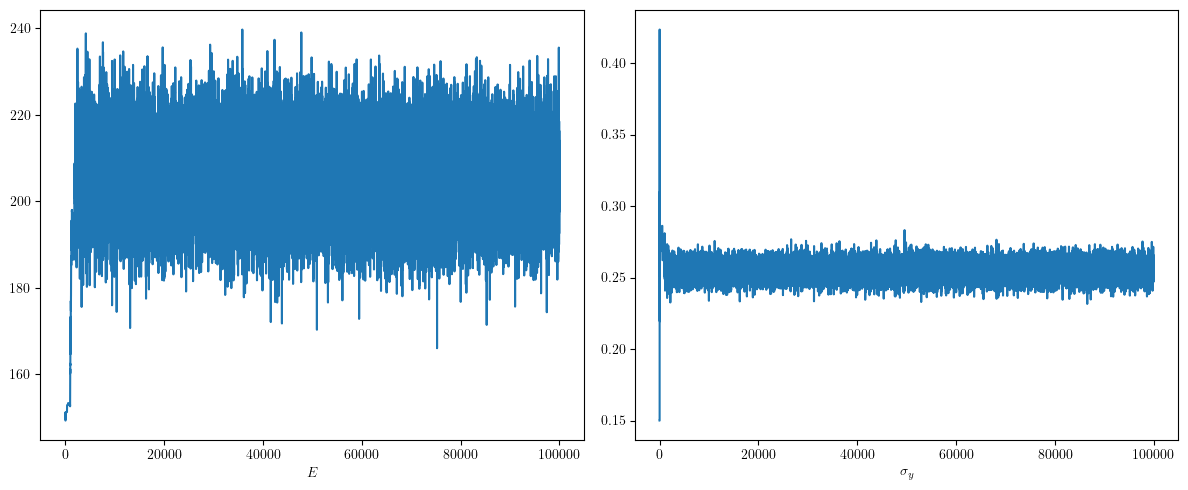

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(samples[:, 0])
ax2.plot(samples[:, 1])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\sigma_y$")
plt.tight_layout()

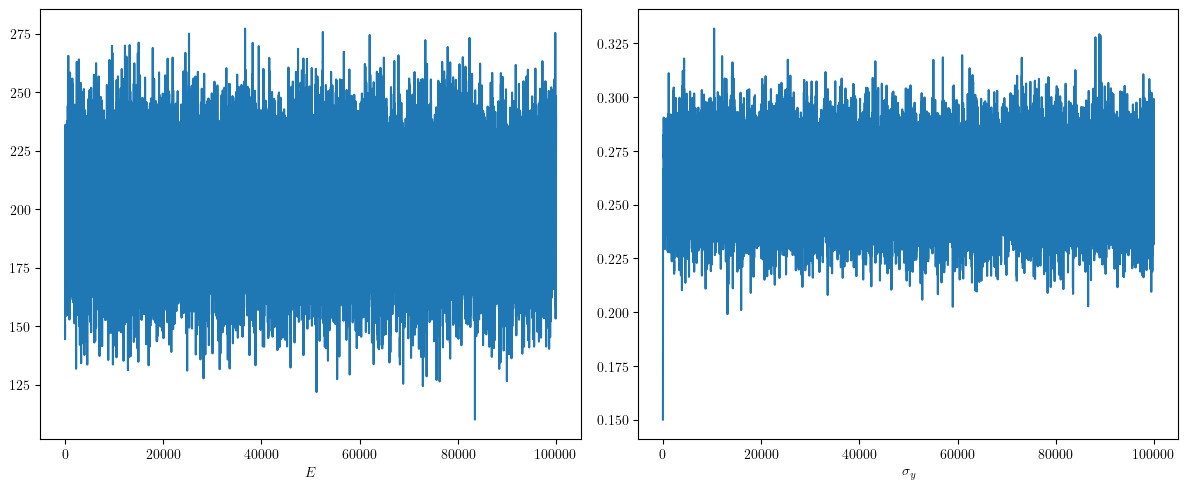

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(samples_surrogate[:, 0])
ax2.plot(samples_surrogate[:, 1])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\sigma_y$")
plt.tight_layout()

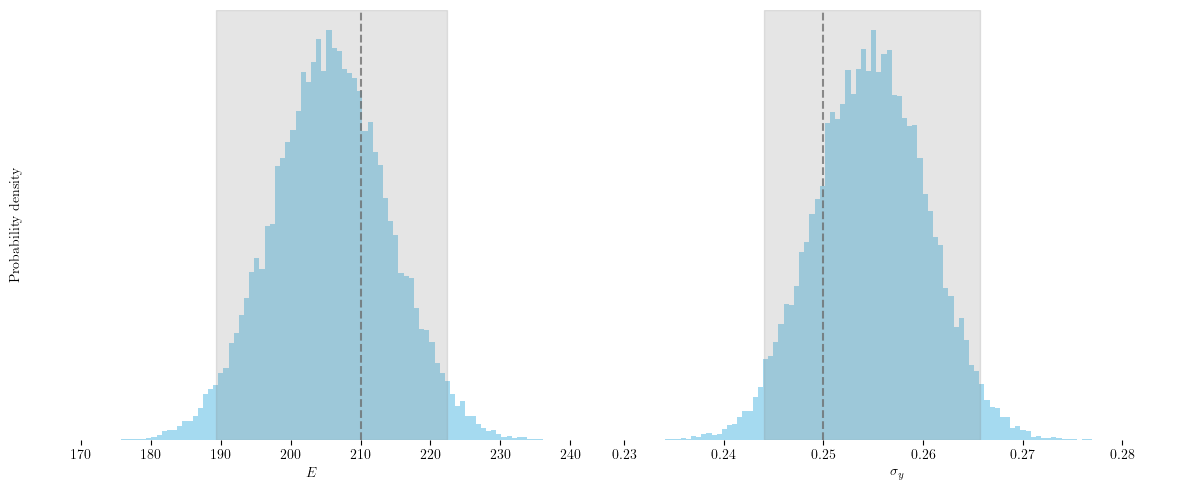

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

credible_interval_E = np.percentile(samples[10000:, 0], [2.5, 97.5])
credible_interval_eps = np.percentile(samples[10000:, 1], [2.5, 97.5])

ax1.hist(samples[10000:, 0], bins=100, density=True, alpha=0.75, color="skyblue")
ax1.axvline(E, ls="--", color="dimgray", alpha=0.75)
ax1.axvspan(credible_interval_E[0], credible_interval_E[1], color="gray", alpha=0.2, label="95% CI")
ax1.set_xlabel("$E$")
ax1.set_ylabel("Probability density")
ax1.tick_params(labelleft=False)
ax1.set_frame_on(False)
ax1.set_yticks([])

ax2.hist(samples[10000:, 1], bins=100, density=True, alpha=0.75, color="skyblue")
ax2.axvline(stress_y, ls="--", color="dimgray", alpha=0.75)
ax2.axvspan(credible_interval_eps[0], credible_interval_eps[1], color="gray", alpha=0.2, label="95% CI")
ax2.set_xlabel("$\sigma_y$")
ax2.tick_params(labelleft=False)
ax2.set_frame_on(False)
ax2.set_yticks([])

plt.tight_layout()

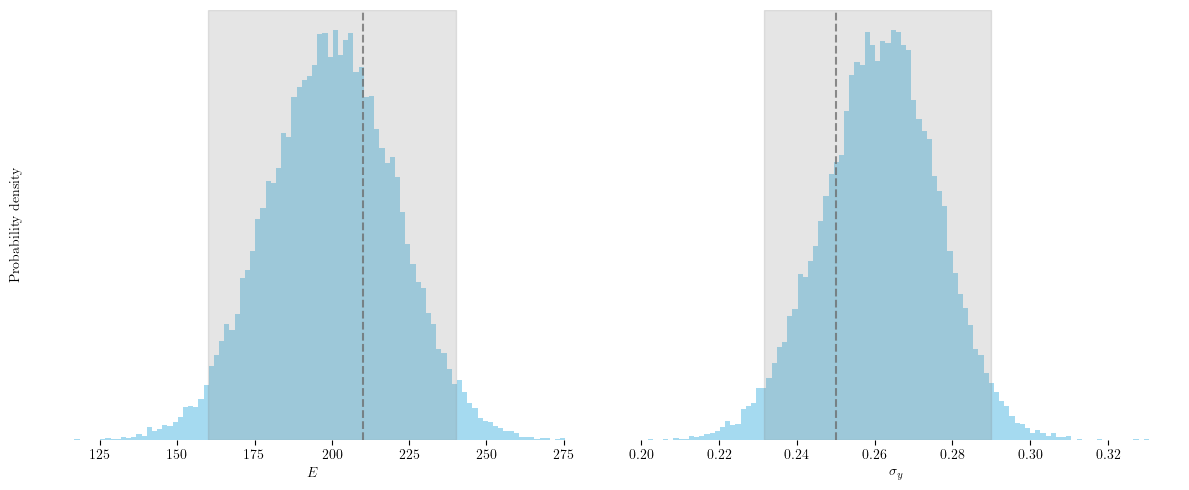

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

credible_interval_E = np.percentile(samples_surrogate[10000:, 0], [2.5, 97.5])
credible_interval_eps = np.percentile(samples_surrogate[10000:, 1], [2.5, 97.5])

ax1.hist(samples_surrogate[10000:, 0], bins=100, density=True, alpha=0.75, color="skyblue")
ax1.axvline(E, ls="--", color="dimgray", alpha=0.75)
ax1.axvspan(credible_interval_E[0], credible_interval_E[1], color="gray", alpha=0.2, label="95% CI")
ax1.set_xlabel("$E$")
ax1.set_ylabel("Probability density")
ax1.tick_params(labelleft=False)
ax1.set_frame_on(False)
ax1.set_yticks([])

ax2.hist(samples_surrogate[10000:, 1], bins=100, density=True, alpha=0.75, color="skyblue")
ax2.axvline(stress_y, ls="--", color="dimgray", alpha=0.75)
ax2.axvspan(credible_interval_eps[0], credible_interval_eps[1], color="gray", alpha=0.2, label="95% CI")
ax2.set_xlabel("$\sigma_y$")
ax2.tick_params(labelleft=False)
ax2.set_frame_on(False)
ax2.set_yticks([])

plt.tight_layout()

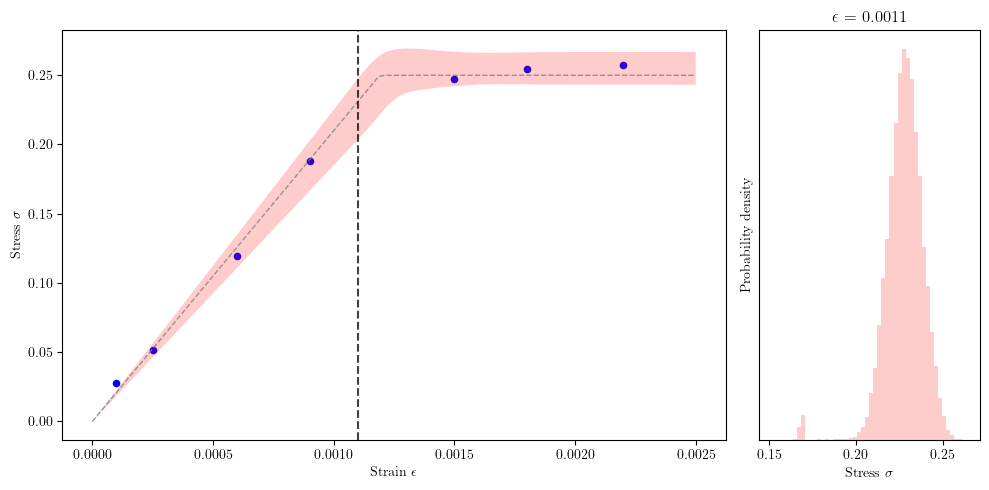

In [26]:
predictions = np.array([true_model.run(np.array([sample[0], sample[1]])) for sample in samples])

posterior_predictive_mean = np.mean(predictions, axis=0)
posterior_predictive_std = np.std(predictions, axis=0)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]}
)

ax1.scatter(strain_observed, stress_observed, color="blue", s=20)
ax1.plot(strain, stress, color='grey', linestyle='--', linewidth=1, alpha=0.8, label="True")
ax1.fill_between(
    strain,
    posterior_predictive_mean - 2 * posterior_predictive_std,
    posterior_predictive_mean + 2 * posterior_predictive_std,
    color="red",
    alpha=0.2,
    edgecolor='none',
    label="Posterior Predictive Distribution",
)

marginal_value = 0.0011
marginal_index = np.abs(strain - marginal_value).argmin()
marginal_posterior = predictions[:, marginal_index]
ax1.axvline(marginal_value, linestyle="--", color="black", alpha=0.75)

ax1.set_xlabel("Strain $\epsilon$")
ax1.set_ylabel("Stress $\sigma$")
# ax1.legend()

ax2.hist(marginal_posterior, bins=50, density=True, alpha=0.2, color="red")
ax2.set_xlabel(f"Stress $\sigma$")
ax2.set_ylabel("Probability density")
ax2.tick_params(labelleft=False)
ax2.set_yticks([])
ax2.set_title(f"$\epsilon$ = {marginal_value}")

plt.tight_layout()

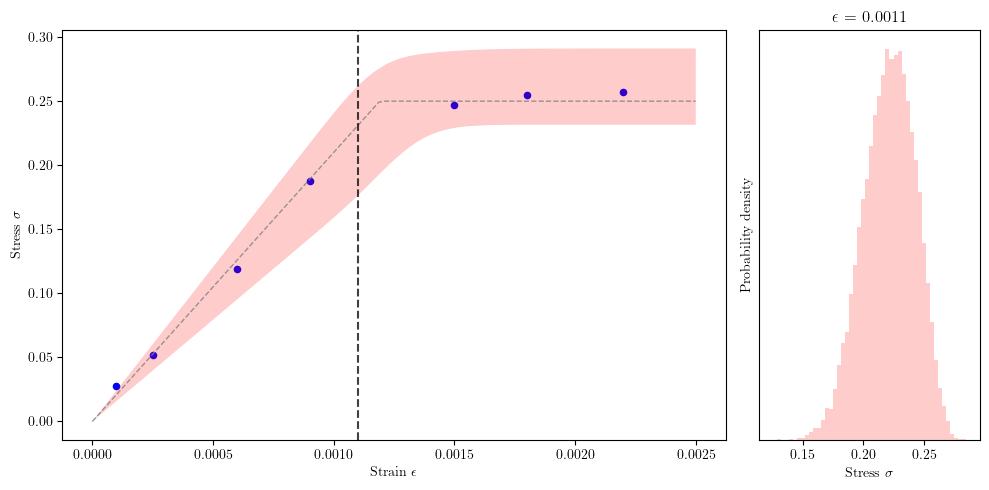

In [27]:
predictions = np.array([true_model.run(np.array([sample[0], sample[1]])) for sample in samples_surrogate])

posterior_predictive_mean = np.mean(predictions, axis=0)
posterior_predictive_std = np.std(predictions, axis=0)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]}
)

ax1.scatter(strain_observed, stress_observed, color="blue", s=20)
ax1.plot(strain, stress, color='grey', linestyle='--', linewidth=1, alpha=0.8, label="True")
ax1.fill_between(
    strain,
    posterior_predictive_mean - 2 * posterior_predictive_std,
    posterior_predictive_mean + 2 * posterior_predictive_std,
    color="red",
    alpha=0.2,
    edgecolor='none',
    label="Posterior Predictive Distribution",
)

marginal_value = 0.0011
marginal_index = np.abs(strain - marginal_value).argmin()
marginal_posterior = predictions[:, marginal_index]
ax1.axvline(marginal_value, linestyle="--", color="black", alpha=0.75)

ax1.set_xlabel("Strain $\epsilon$")
ax1.set_ylabel("Stress $\sigma$")
# ax1.legend()

ax2.hist(marginal_posterior, bins=50, density=True, alpha=0.2, color="red")
ax2.set_xlabel(f"Stress $\sigma$")
ax2.set_ylabel("Probability density")
ax2.tick_params(labelleft=False)
ax2.set_yticks([])
ax2.set_title(f"$\epsilon$ = {marginal_value}")

plt.tight_layout()